## Download Plume Prediction Map
https://firesmoke.ca/data/

User-defined variables

In [5]:
# Grid and domainfile
gridfile = 'drive/MyDrive/grid.pkl'
# Output file name to save the plume prediction data
outfile  ='drive/MyDrive/sim_data20230626.txt'

## Google Colab Environment

In [2]:
pip install ipyleaflet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.7 MB/s eta 0:00:00


In [3]:
pip install netCDF4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 41.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.3 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Download the Plume Simulation Map

In [6]:
import requests
import pickle

In [7]:
url = 'https://firesmoke.ca/forecasts/BSC06CA12-01/2023062614/dispersion.nc'
r = requests.get(url, allow_redirects=True)
open('dispersion.nc', 'wb').write(r.content)

84031236

In [8]:
# Grid
f = open(gridfile,"rb")
grid = pickle.load(f)
f.close()

## Visualize the Plume Simulation Map

In [9]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np

In [10]:
fn = 'dispersion.nc'
ds = nc.Dataset(fn)

In [11]:
ds

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    IOAPI_VERSION: $Id: @(#) ioapi library version 3.0 $                                           
    EXEC_ID: ????????????????                                                                
    FTYPE: 1
    CDATE: 2023177
    CTIME: 165117
    WDATE: 2023177
    WTIME: 165117
    SDATE: 2023177
    STIME: 150000
    TSTEP: 10000
    NTHIK: 1
    NCOLS: 1081
    NROWS: 381
    NLAYS: 1
    NVARS: 1
    GDTYP: 1
    P_ALP: 0.0
    P_BET: 0.0
    P_GAM: 0.0
    XCENT: -106.0
    YCENT: 51.0
    XORIG: -160.0
    YORIG: 32.0
    XCELL: 0.10000000149011612
    YCELL: 0.10000000149011612
    VGTYP: 5
    VGTOP: -9999.0
    VGLVLS: [10.  0.]
    GDNAM: HYSPLIT CONC    
    UPNAM: hysplit2netCDF  
    VAR-LIST: PM25            
    FILEDESC: Hysplit Concentration Model Output                                              lat-lon coordinate system                                                  

In [12]:
z = ds['PM25'][0,0,:,:]
z = np.float64(z.data)
z[z<1e-20] = 1e-20

## Extract the Simulation Data on the Grid

In [13]:
import scipy

In [14]:
# extract small domain
sw = grid['sw']
ne = grid['ne']
lat = np.linspace(ds.YORIG, ds.YORIG+(ds.NROWS-1)*ds.YCELL,ds.NROWS)
lon = np.linspace(ds.XORIG, ds.XORIG+(ds.NCOLS-1)*ds.XCELL,ds.NCOLS)

iy_sw = np.argmin(np.abs(lat-sw[0]))-1
ix_sw = np.argmin(np.abs(lon-sw[1]))-1
iy_ne = np.argmin(np.abs(lat-ne[0]))+1
ix_ne = np.argmin(np.abs(lon-ne[1]))+1

sw = np.array([lat[iy_sw], lon[ix_sw]])
ne = np.array([lat[iy_ne], lon[ix_ne]])
z = z[iy_sw:iy_ne,ix_sw:ix_ne]
z = np.log10(z)

In [15]:
z.shape

(32, 49)

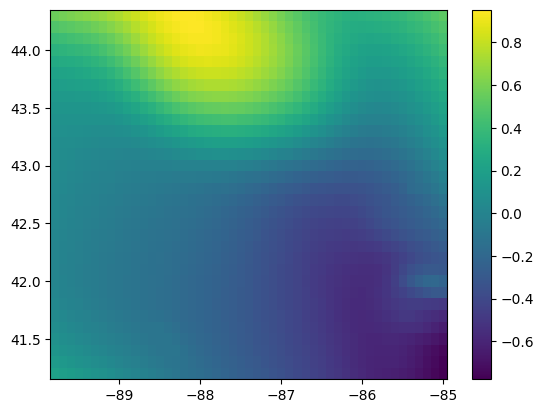

In [16]:
lon_grid,lat_grid= np.meshgrid(lon[ix_sw:ix_ne], lat[iy_sw:iy_ne])
plt.pcolormesh(lon_grid,lat_grid,z, cmap="viridis")
plt.colorbar()
data = np.column_stack((lon_grid.flatten(),lat_grid.flatten(),z.flatten()))

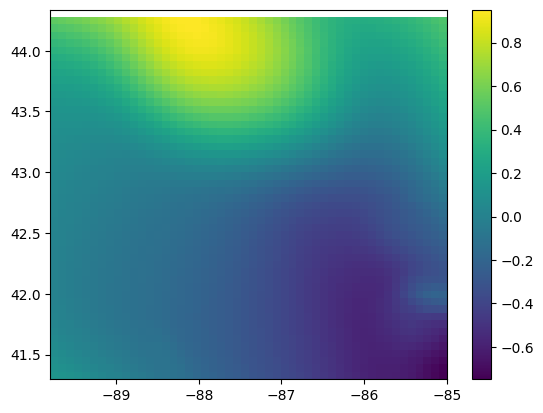

In [17]:
zz = scipy.interpolate.griddata((lat_grid.flatten(),lon_grid.flatten()),z.flatten(),(grid['xx0'],grid['xx1']))
plt.pcolormesh(grid['xx1'], grid['xx0'],zz, cmap="viridis")
plt.colorbar()

In [18]:
np.savetxt(outfile,zz)

## Overlay the Simulation Data on the Grid

In [19]:
from base64 import b64encode
from io import StringIO, BytesIO
import PIL

from ipyleaflet import Map, ImageOverlay

In [20]:
zz = (zz-np.min(zz[~np.isnan(zz)]))/(np.max(zz[~np.isnan(zz)])-np.min(zz[~np.isnan(zz)]))
zz = np.transpose(zz)
zz = np.flipud(zz)
z_im = PIL.Image.fromarray(np.uint8(plt.cm.jet(zz) * 255))
im = PIL.Image.new("RGBA", zz.shape, color=None)
im.paste(z_im)

In [21]:
fio = BytesIO()
im.save(fio, "png")
data = b64encode(fio.getvalue())
data = data.decode("ascii")
imgurl = "data:image/png;base64," + data

In [22]:
m = Map(center=grid['center'], zoom=7)
image = ImageOverlay(
    url=imgurl,
    bounds=((sw[0],sw[1]), (ne[0],ne[1])),
    opacity=0.7
)

m.add_layer(image);
m

Map(center=[42.8172225, -87.39416800000001], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…